# Import Libraries & Data

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import warnings

from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score, recall_score, matthews_corrcoef

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from my_module import *
from IPython.core.display import display, HTML

display(HTML('<style>.container { width:80% !important; }</style>'))
warnings.filterwarnings('ignore')
scaler = StandardScaler()

## Data

In [2]:
df = pd.read_csv('yelp_review_processed.csv')
with pd.option_context('display.max_colwidth', 20):
    display(df.head())

,review,review_clean,review_stars,set_word,number_of_photos,number_of_price,number_of_time,number_of_emots,average_useful_vote,review_age_days,review_useful
0,"""River, we see t...",river yelp place...,5.0,159,0,0,0,0,2.375,2157,6
1,Gave this restau...,give restaur sta...,3.0,133,0,0,1,5,0.000,2331,0
2,Oh boy! I love v...,boy love veggi r...,4.0,103,0,0,0,2,0.000,1245,0
3,This was my firs...,vegan meal famil...,5.0,33,0,0,0,0,0.000,1417,0
4,Visited the Vegg...,visit veggi hous...,5.0,72,0,0,0,1,0.000,1853,0


In [3]:
# only use text and extracted qualitative features
X = df.drop(['review_clean', 'review_useful'], axis=1)
# all reviews which have 5 or greater helpful votes are labeled as helpful
# all other reviews are in the not helpful category
y = np.where(df.review_useful > 4, 1, 0)

In [4]:
# split into train and test set
X_train, X_test, y_train, y_test = train_test_split(
                                        X, y, test_size=0.2, random_state=1)
print("""
        Number of helpful reviews in the training data: {:,}
        Number of helpful reviews in the test data: {:,}
        
        Distribution of the positive class in the training data: {:.2f}%
        Distribution of the positive class in the test data: {:.2f}%
        
        The class distributions are pretty close both in the training and the
        test data which will ensure the stability of the algorithms.
      """
      .format(y_train.sum(), y_test.sum(),
              (y_train[y_train == 1].size / y_train.size) * 100, 
              (y_test[y_test == 1].size / y_test.size) * 100))


        Number of helpful reviews in the training data: 29,462
        Number of helpful reviews in the test data: 7,483
        
        Distribution of the positive class in the training data: 5.03%
        Distribution of the positive class in the test data: 5.11%
        
        The class distributions are pretty close both in the training and the
        test data which will ensure the stability of the algorithms.
      


In [5]:
# will be used later to determine model performance
temp = X_test.loc[:, 'review'].to_frame()
temp = temp.merge(df.loc[temp.index, 'review_useful'], left_index=True, right_index=True)
top_10_helpful_votes = sorted(temp.review_useful.unique(), reverse=True)[:10]
temp['is_top_10'] = temp.review_useful.isin(top_10_helpful_votes).astype(np.int)
temp.head()

,review,review_useful,is_top_10
449320,Simply delicious. I had the pork chop and my c...,0,0
198748,"Great menu, great beers, huge enormous giganti...",0,0
86433,Came here for lunch while staying at Aria. Def...,0,0
79060,"This casual, contempary joint reminds me of a ...",3,0
27334,Went to the dog park up the road and grabbed s...,2,0


# Train the Models

In [6]:
X_train = X_train.drop('review', axis=1).values
X_test = X_test.drop('review', axis=1).values

In [7]:
lr = LogisticRegression(C=100, class_weight='balanced', solver='lbfgs')
dt = DecisionTreeClassifier()
rf = RandomForestClassifier(max_features='log2', n_estimators=1000)
et = ExtraTreesClassifier(max_features='log2', n_estimators=1000)
xgb = XGBClassifier(colsample_bytree=0.8, eta=0.1)
knn = KNeighborsClassifier(n_neighbors=20)

In [8]:
estimators = [('Logistic Regression', lr),
              ('KNN Classifier', knn),
              ('Decision Tree Classifier', dt),
              ('Random Forest Classifier', rf),
              ('Extra Trees Classifier', et),
              ('XGBoost Classifier', xgb)]
scalers = [True, True, False, False, False, False, False, False]
training_scores = train_model(
    estimators=estimators, X=X_train, y=y_train, scalers=scalers)
training_scores_, _ = calculate_statistics(training_scores)
df_training = make_df_statistics(training_scores_)
df_training

,matthews_corrcoef,roc_auc_score,pr_auc_score
Logistic Regression,0.574228,0.976031,0.726150
KNN Classifier,0.639759,0.981817,0.775516
Decision Tree Classifier,0.999946,1.000000,1.000000
Random Forest Classifier,0.999946,1.000000,1.000000
Extra Trees Classifier,0.999946,1.000000,1.000000
XGBoost Classifier,0.688801,0.982024,0.793842


# Test the Models

In [9]:
test_scores = test_model(estimators=estimators,
                         X=X_test, y=y_test, scalers=scalers)
test_scores_, _ = calculate_statistics(test_scores)
df_test = make_df_statistics(test_scores_)
df_test

,matthews_corrcoef,roc_auc_score,pr_auc_score
Logistic Regression,0.568460,0.976048,0.727485
KNN Classifier,0.634249,0.952136,0.720750
Decision Tree Classifier,0.569240,0.787712,0.601788
Random Forest Classifier,0.675727,0.975558,0.766535
Extra Trees Classifier,0.655322,0.972175,0.737749
XGBoost Classifier,0.685592,0.980665,0.783915


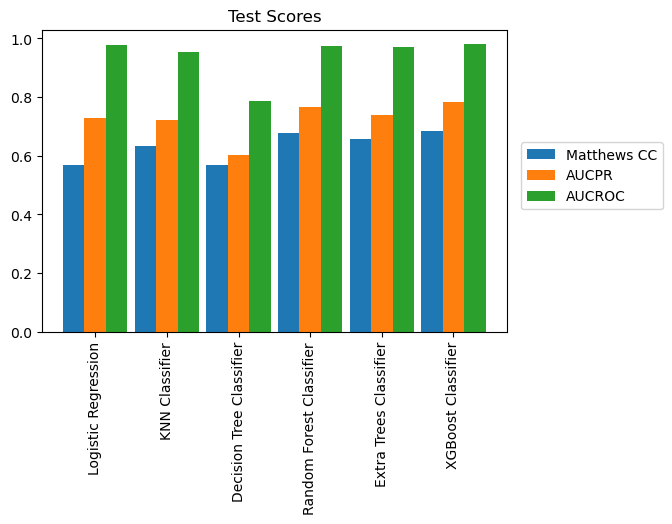

In [10]:
fig, ax = plt.subplots()  # generates figure and axes object
fig.set_dpi(100)  # set the resolution of the plot
width = 0.3  # set bar width
idx = np.arange(
    df_test.shape[0])  # number of ticks for x-axis and bar location
# plots matthews correlation coef.
ax.bar(idx, df_test.matthews_corrcoef, width)
ax.bar(idx + width, df_test.pr_auc_score, width)  # plots AUCPR
ax.bar(idx + width * 2, df_test.roc_auc_score, width)
ax.set_xticks(idx + 0.3)  # adjust the position of xticks
ax.set_xticklabels(df_test.index, rotation=90)  # changes the tick labels
ax.legend(['Matthews CC', 'AUCPR', 'AUCROC'],
          bbox_to_anchor=(1.35, 0.65))  # set the legend
ax.set_title('Test Scores')
plt.show()  # shows the plot

# Confusion Matrices

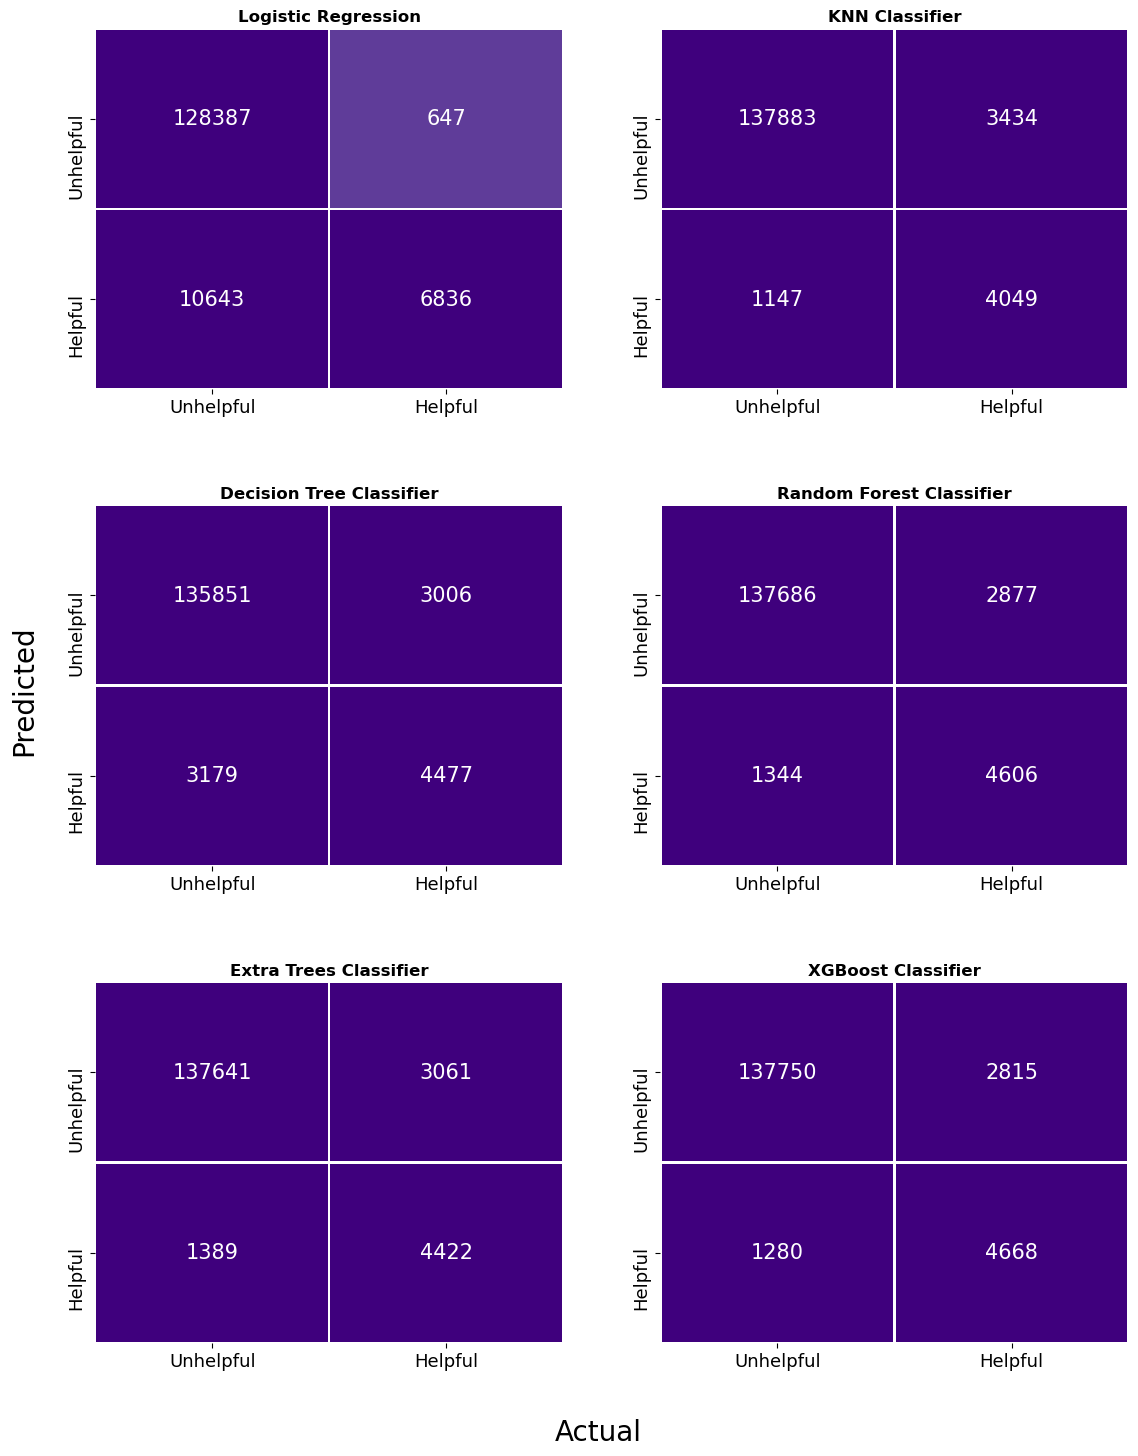

In [11]:
predicted_values_all = []
for model in df_test.index:
    predicted_values_all.append(test_scores[model]['predictions'][0])

fig, axes = plt.subplots(3, 2, figsize=(12, 15))
fig.set_dpi(100)
axes = axes.ravel()

for idx, model in enumerate(df_test.index):
    plot_confusion_matrix(
        y=y_test, predictions=predicted_values_all[idx], title=model, ax=axes[idx], ticklabels=['Unhelpful', 'Helpful'], cmap='Purples', cbar=False)
fig.text(0.5, 0, 'Actual', ha='center', size=20)
fig.text(0.01, 0.5, 'Predicted', va='center', size=20, rotation='vertical')
plt.tight_layout(5)
plt.show()

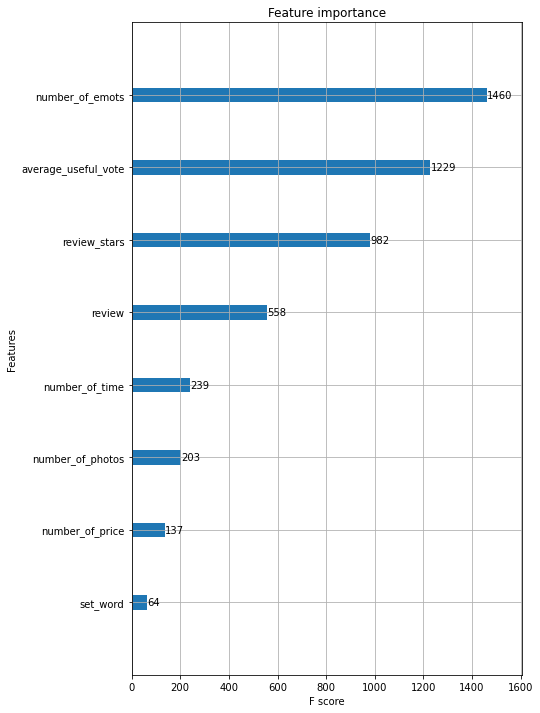

In [12]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(7, 12))
xgb.get_booster().feature_names = list(df.drop(['review_clean',
                                                'review_useful'], axis=1).columns)
plot_importance(xgb, ax=ax)
plt.show()

# Check Top Predicted Useful Reviews

In [13]:
print("""
        Among {:,} reviews in the test data, {:,} reviews are among those that 
        have one of the top 10 helpful votes.
      """
      .format(temp.shape[0], temp.is_top_10.values.sum()))


        Among 146,513 reviews in the test data, 11 reviews are among those that 
        have one of the top 10 helpful votes.
      


        Top 10 helpful votes are decided by taking the unique values among
        the helpful votes, arranging them in descending order and taking the
        first 10 number of helpful votes. For this reason, there may be more
        than 10 review which have the highest 10 helpful votes.
        
        The aim is to decide, firstly, if an algorithm is able to distinguish
        helpful reviews from unhelpful reviews. Secondly, among those reviews
        that are predicted to be helpful, how may reviews are among the reviews
        that have top 10 helpful votes.
        
        In other words, we would like to measure how many of the predicted helpful
        reviews will be among the reviews that have the highest helpful votes
        in the real life.
        
        It is easy to come up with predictions but we would like to determine
        the also the quality of those predictions.

        In the confusion matrices, we see that:
            1. Logistic Regression predicted the highest number of useful review in expense of false positives.
               Moreover, it has the lowest false negative rate among all algorithms.
            2. KNN predicted an average number of useful reviews with the lowest false positive rate.
               However, it has the greatest number of false negatives.
            3. All other algorithms stays in the spectrum where the edges are Logistic Regression and KNN algorithms.
               Among the remaining algorithms, Random Forest and XGBoost algorithms are the top algorithms.

        In this stage, we will look the top 30 helpful reviews predicted by all algorithms and their true helpful votes.
        This kind of approach will provide better understanding of the results. The aim is to find the algorithm which
        predicted the helpful reviews which has the highest true votes with the highest precision.

## Logistic Regression

In [14]:
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
lr = LogisticRegression(C=100, class_weight='balanced', solver='lbfgs')
lr.fit(X_train_scaled, y_train)
predicted_probas_lr = lr.predict_proba(X_test_scaled)
predicted_probas_lr = [round(proba[1], 4) for proba in predicted_probas_lr]
temp['lr_probas'] = predicted_probas_lr

In [16]:
with pd.option_context('display.max_row', None):
    display(temp.sort_values(['lr_probas','review_useful'], ascending=[False, False]).head(30))

,review,review_useful,is_top_10,lr_probas
120715,Eggslut has opened a few locations in the Los ...,213,1,1.0
173345,"""Food is such a powerful lil hoe, she could ta...",162,1,1.0
401294,DO NOT VISIT THIS CASINO! There were a ton of ...,161,1,1.0
82531,"Shang's commitment to quality ingredients, fri...",139,1,1.0
620450,"Charlie Rose: ""Here's the big question: Is Dav...",138,1,1.0
510665,I respect Chef José Andrés immensely but I can...,133,1,1.0
58714,"Lawry's Fact: They serve 750,000 lbs. of meat...",130,1,1.0
185348,Eating at Nobu is like breaking out an old rec...,124,1,1.0
404570,One day after a meeting my coworker and I stop...,121,1,1.0
71239,We were on our way to a very late breakfast at...,117,1,1.0


## KNN

In [17]:
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train_scaled, y_train)
predicted_probas_knn = knn.predict_proba(X_test_scaled)
predicted_probas_knn = [round(proba[1], 4) for proba in predicted_probas_knn]
temp['knn_probas'] = predicted_probas_knn

In [18]:
with pd.option_context('display.max_row', None):
    display(temp.sort_values(['knn_probas','review_useful'], ascending=[False, False]).head(30))

,review,review_useful,is_top_10,lr_probas,knn_probas
173345,"""Food is such a powerful lil hoe, she could ta...",162,1,1.0,1.0
401294,DO NOT VISIT THIS CASINO! There were a ton of ...,161,1,1.0,1.0
82531,"Shang's commitment to quality ingredients, fri...",139,1,1.0,1.0
620450,"Charlie Rose: ""Here's the big question: Is Dav...",138,1,1.0,1.0
510665,I respect Chef José Andrés immensely but I can...,133,1,1.0,1.0
58714,"Lawry's Fact: They serve 750,000 lbs. of meat...",130,1,1.0,1.0
185348,Eating at Nobu is like breaking out an old rec...,124,1,1.0,1.0
404570,One day after a meeting my coworker and I stop...,121,1,1.0,1.0
573605,I like hashtags because they look like waffles...,117,1,1.0,1.0
186493,It's hard to even imagine that what was once a...,112,0,1.0,1.0


## Decision Tree

In [19]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
predicted_probas_dt = dt.predict_proba(X_test)
predicted_probas_dt = [round(proba[1], 4) for proba in predicted_probas_dt]
temp['dt_probas'] = predicted_probas_dt

In [20]:
with pd.option_context('display.max_row', None):
    display(temp.sort_values(['dt_probas','review_useful'], ascending=[False, False]).head(30))

,review,review_useful,is_top_10,lr_probas,knn_probas,dt_probas
120715,Eggslut has opened a few locations in the Los ...,213,1,1.0,0.95,1.0
173345,"""Food is such a powerful lil hoe, she could ta...",162,1,1.0,1.00,1.0
401294,DO NOT VISIT THIS CASINO! There were a ton of ...,161,1,1.0,1.00,1.0
82531,"Shang's commitment to quality ingredients, fri...",139,1,1.0,1.00,1.0
620450,"Charlie Rose: ""Here's the big question: Is Dav...",138,1,1.0,1.00,1.0
510665,I respect Chef José Andrés immensely but I can...,133,1,1.0,1.00,1.0
58714,"Lawry's Fact: They serve 750,000 lbs. of meat...",130,1,1.0,1.00,1.0
185348,Eating at Nobu is like breaking out an old rec...,124,1,1.0,1.00,1.0
404570,One day after a meeting my coworker and I stop...,121,1,1.0,1.00,1.0
71239,We were on our way to a very late breakfast at...,117,1,1.0,0.95,1.0


## Random Forest

In [21]:
rf = RandomForestClassifier(max_features='log2', n_estimators=1000)
rf.fit(X_train, y_train)
predicted_probas_rf = rf.predict_proba(X_test)
predicted_probas_rf = [round(proba[1], 4) for proba in predicted_probas_rf]
temp['rf_probas'] = predicted_probas_rf

In [22]:
with pd.option_context('display.max_row', None):
    display(temp.sort_values(['rf_probas','review_useful'], ascending=[False, False]).head(30))

,review,review_useful,is_top_10,lr_probas,knn_probas,dt_probas,rf_probas
50167,Having heard great things about Mesa Grill for...,48,0,1.0000,1.00,1.0,1.000
562885,Your eyes don't deceive you...The Mirage is tr...,42,0,1.0000,1.00,1.0,1.000
135915,"OK, this place has been on my bookmarks for se...",36,0,1.0000,1.00,1.0,1.000
232114,Nora's is one of those places that is consiste...,27,0,1.0000,1.00,1.0,1.000
592365,We came back again as it's been a while since ...,26,0,1.0000,0.95,1.0,1.000
38350,My love for boba has completely been revived. ...,18,0,1.0000,0.95,1.0,1.000
620450,"Charlie Rose: ""Here's the big question: Is Dav...",138,1,1.0000,1.00,1.0,0.999
376181,I bookmarked this place over 4 years ago when ...,51,0,1.0000,0.85,1.0,0.999
535779,Had planned to meet up with Yelp buds Angela T...,49,0,1.0000,1.00,1.0,0.999
25905,Love him or hate him... the then candidate Mr....,44,0,1.0000,1.00,1.0,0.999


## Extra Trees

In [23]:
et = ExtraTreesClassifier(max_features='log2', n_estimators=1000)
et.fit(X_train, y_train)
predicted_probas_et = et.predict_proba(X_test)
predicted_probas_et = [round(proba[1], 4) for proba in predicted_probas_et]
temp['et_probas'] = predicted_probas_et

In [24]:
with pd.option_context('display.max_row', None):
    display(temp.sort_values(['et_probas','review_useful'], ascending=[False, False]).head(30))

,review,review_useful,is_top_10,lr_probas,knn_probas,dt_probas,rf_probas,et_probas
135915,"OK, this place has been on my bookmarks for se...",36,0,1.0000,1.00,1.0,1.000,1.000
551442,They say breakfast is the most important meal ...,13,0,1.0000,1.00,1.0,0.975,1.000
611306,"I do so enjoy a great local craft brew, but th...",5,0,1.0000,1.00,1.0,0.992,1.000
609242,The food here is delicious! No matter what you...,2,0,0.1810,0.05,1.0,0.648,1.000
183165,the slider trio was excellent the slaw on the ...,0,0,0.9780,0.55,1.0,0.803,1.000
283685,"Come hungry, leave happy. How hungry are you? ...",91,0,1.0000,1.00,1.0,0.993,0.999
328023,We had some people for out of town visiting an...,53,0,1.0000,0.95,1.0,0.993,0.999
487254,Located on the promenade level of the contempo...,28,0,1.0000,1.00,1.0,0.997,0.999
82354,"I'm a big fan of noodle, it has such a magical...",70,0,1.0000,1.00,1.0,0.995,0.998
376181,I bookmarked this place over 4 years ago when ...,51,0,1.0000,0.85,1.0,0.999,0.998


## XGBoost Classifier

In [25]:
xgb = XGBClassifier(colsample_bytree=0.8, eta=0.1)
xgb.fit(X_train, y_train)
predicted_probas_xgb = xgb.predict_proba(X_test)
predicted_probas_xgb = [round(proba[1], 4) for proba in predicted_probas_xgb]
temp['xgb_probas'] = predicted_probas_xgb

In [26]:
with pd.option_context('display.max_row', None):
    display(temp.sort_values(['xgb_probas','review_useful'], ascending=[False, False]).head(30))

,review,review_useful,is_top_10,lr_probas,knn_probas,dt_probas,rf_probas,et_probas,xgb_probas
620450,"Charlie Rose: ""Here's the big question: Is Dav...",138,1,1.0,1.00,1.0,0.999,0.996,0.9963
315946,Bonjour Paris without the flight. This is by f...,28,0,1.0,1.00,1.0,0.994,0.971,0.9951
620155,I really have a love hate relationship with Mo...,71,0,1.0,1.00,1.0,0.991,0.973,0.9948
237362,Bobby Flay seems to be everywhere these days. ...,34,0,1.0,0.90,1.0,0.979,0.973,0.9943
570478,Sage is located in the Aria Hotel. The ambian...,29,0,1.0,0.85,1.0,0.994,0.984,0.9942
82354,"I'm a big fan of noodle, it has such a magical...",70,0,1.0,1.00,1.0,0.995,0.998,0.9940
50167,Having heard great things about Mesa Grill for...,48,0,1.0,1.00,1.0,1.000,0.997,0.9940
25905,Love him or hate him... the then candidate Mr....,44,0,1.0,1.00,1.0,0.999,0.994,0.9940
341757,"""This beautiful woman just literally tripped a...",43,0,1.0,1.00,1.0,0.989,0.994,0.9938
2864,Cafe Sanuki is a Japanese cafeteria style rest...,35,0,1.0,1.00,1.0,0.986,0.975,0.9937


In [27]:
threshold = 0.95  # confidence threshold for algorithms
print("""
        The recall ratio for predicted helpful reviews with 0.95 confidence
        (the reviews that have assigned probability 0.95 or above):    
        
            * {:<20}\t{:.2f}%\t{:>6,} out of {:>5,}
            * {:<20}\t{:.2f}%\t{:>6,} out of {:>5,}
            * {:<20}\t{:.2f}%\t{:>6,} out of {:>5,}
            * {:<20}\t{:.2f}%\t{:>6,} out of {:>5,}
            * {:<20}\t{:.2f}%\t{:>6,} out of {:>5,}
            * {:<20}\t{:.2f}%\t{:>6,} out of {:>5,}
      """.format(
    'Logistic Regression',
    (temp[(temp.lr_probas >= threshold) & (temp.review_useful >= 5)].shape[0] /
    temp[temp.lr_probas >= threshold].shape[0]) * 100,
    temp[(temp.lr_probas >= threshold) & (temp.review_useful >= 5)].shape[0],
    temp[(temp.lr_probas >= threshold)].shape[0],
    'KNN',
    (temp[(temp.knn_probas >= threshold) & (temp.review_useful >= 5)].shape[0] /
    temp[temp.knn_probas >= threshold].shape[0]) * 100,
    temp[(temp.knn_probas >= threshold) & (temp.review_useful >= 5)].shape[0],
    temp[(temp.knn_probas >= threshold)].shape[0],
    'Decision Tree',
    (temp[(temp.dt_probas >= threshold) & (temp.review_useful >= 5)].shape[0] /
    temp[temp.dt_probas >= threshold].shape[0]) * 100,
    temp[(temp.dt_probas >= threshold) & (temp.review_useful >= 5)].shape[0],
    temp[(temp.dt_probas >= threshold)].shape[0],
    'Random Forest',
    (temp[(temp.rf_probas >= threshold) & (temp.review_useful >= 5)].shape[0] /
    temp[temp.rf_probas >= threshold].shape[0]) * 100,
    temp[(temp.rf_probas >= threshold) & (temp.review_useful >= 5)].shape[0],
    temp[(temp.rf_probas >= threshold)].shape[0],
    'Extra Trees',
    (temp[(temp.et_probas >= threshold) & (temp.review_useful >= 5)].shape[0] /
    temp[temp.et_probas >= threshold].shape[0]) * 100,
    temp[(temp.et_probas >= threshold) & (temp.review_useful >= 5)].shape[0],
    temp[(temp.et_probas >= threshold)].shape[0],
    'XGBoost',
    (temp[(temp.xgb_probas >= threshold) & (temp.review_useful >= 5)].shape[0] /
    temp[temp.xgb_probas >= threshold].shape[0]) * 100,
    temp[(temp.xgb_probas >= threshold) & (temp.review_useful >= 5)].shape[0],
    temp[(temp.xgb_probas >= threshold)].shape[0]))


        The recall ratio for predicted helpful reviews with 0.95 confidence
        (the reviews that have assigned probability 0.95 or above):    
        
            * Logistic Regression 	71.98%	 4,853 out of 6,742
            * KNN                 	95.16%	   904 out of   950
            * Decision Tree       	58.44%	 4,490 out of 7,683
            * Random Forest       	96.41%	   913 out of   947
            * Extra Trees         	95.65%	   594 out of   621
            * XGBoost             	97.91%	   656 out of   670
      


        As we discussed in the confusion matrices section, XGBoost and Random Forest
        are the top algorithms. We can also see that from the recall rates, the ratio
        of true helpful reviews to predicted helpful reviews for the reviews that have
        0.95 or above assigned probability, are the highest among all algorithms.
        
        Another important point is that Decision Tree and Logistic Regression have the
        lowest recall rate among all algorithms. However, they are better than all other
        algorithms in terms of predicting the true helpful reviews with the highest 
        helpful votes. For this reason, we can say that Logistic Regression and Decision
        Tree have a naiver approach than all other algorithms. 
        
        In this project, our perspective is not solely to approach the problem as a pure
        classification problem but to be able to recommend among the freshly posted reviews
        that would have the highest helpful votes.
        
        Finally we will investigate how much success an algorithm has identifying the
        helpful reviews that have the highest number of helpful votes. Since those reviews
        are at the top they should have assigned probabilities that are close to 1.0.
        

In [28]:
N = temp.is_top_10.sum()

print("""       
        * {:<20}\t{:>3,} out of {:>2,}
        * {:<20}\t{:>3,} out of {:>2,}
        * {:<20}\t{:>3,} out of {:>2,}
        * {:<20}\t{:>3,} out of {:>2,}
        * {:<20}\t{:>3,} out of {:>2,}
        * {:<20}\t{:>3,} out of {:>2,}   
      """
      .format(
      'Logistic Regression',
      temp[temp.lr_probas >= threshold].is_top_10.sum(), N,
      'KNN',
      temp[temp.knn_probas >= threshold].is_top_10.sum(), N,
      'Decision Tree',
      temp[temp.dt_probas >= threshold].is_top_10.sum(), N,
      'Random Forest',
      temp[temp.rf_probas >= threshold].is_top_10.sum(), N,
      'Extra Trees',
      temp[temp.et_probas >= threshold].is_top_10.sum(), N,
      'XGBoost',
      temp[temp.xgb_probas >= threshold].is_top_10.sum(), N))

       
        * Logistic Regression 	 11 out of 11
        * KNN                 	 11 out of 11
        * Decision Tree       	 11 out of 11
        * Random Forest       	  9 out of 11
        * Extra Trees         	 10 out of 11
        * XGBoost             	  8 out of 11   
      


        We set 0.95 as the threshold for the assigned probabilities in order to increase the recall rate.
        By doing this, we hope to avoid false positives so that the business owners (the restaurants in
        this case) will be more likely to provide the customers with the reviews that can attract their
        attention and present what they are looking for. Also, they can promote those reviews among the
        others so that it will be easier for the customers to reach the relevant information about the
        business and the product(s).

# The Learning Curves

        In this section, we will asses the performance of KNN and XGBoost algorithms with respect to different
        sizes of training set in order to see how performance changes based on the number of reviews.

In [29]:
# get random numbers as indices
train_1k_idx = np.random.randint(X_train.shape[0], size=1000)
train_10k_idx = np.random.randint(X_train.shape[0], size=10000)
train_50k_idx = np.random.randint(X_train.shape[0], size=50000)
train_100k_idx = np.random.randint(X_train.shape[0], size=100000)
train_250k_idx = np.random.randint(X_train.shape[0], size=250000)

In [30]:
# set training sets in different sizes
train_1k = X_train[train_1k_idx]
train_10k = X_train[train_10k_idx]
train_50k = X_train[train_50k_idx]
train_100k = X_train[train_100k_idx]
train_250k = X_train[train_250k_idx]

In [31]:
# set the target variable using the same indices
test_1k = y_train[train_1k_idx]
test_10k = y_train[train_10k_idx]
test_50k = y_train[train_50k_idx]
test_100k = y_train[train_100k_idx]
test_250k = y_train[train_250k_idx]

In [32]:
training_sets = [train_1k, train_10k, train_50k, train_100k, train_250k, X_train]
validation_sets = [test_1k, test_10k, test_50k, test_100k, test_250k, y_train]
sets = ['train_1k', 'train_10k', 'train_50k', 'train_100k', 'train_250k', 'train_all']

In [33]:
lr = LogisticRegression(C=100, class_weight='balanced', solver='lbfgs')
dt = DecisionTreeClassifier()
rf = RandomForestClassifier(max_features='log2', n_estimators=1000)
et = ExtraTreesClassifier(max_features='log2', n_estimators=1000)
xgb = XGBClassifier(colsample_bytree=0.8, eta=0.1)
knn = KNeighborsClassifier(n_neighbors=20)

In [34]:
estimators = [('Logistic Regression', lr),
              ('KNN Classifier', knn),
              ('Decision Tree Classifier', dt),
              ('Random Forest Classifier', rf),
              ('Extra Trees Classifier', et),
              ('XGBoost Classifier', xgb)]

In [35]:
# dict to store metrics
d = {name: {set_name : {} for set_name in sets} for name, _ in estimators}

In [36]:
for name, model in estimators:
    for x_train, y_validation, set_name in zip(training_sets, validation_sets, sets):
        
        clf = clone(model)
        
        if name in ['Logistic Regression', 'KNN']:
            sc = StandardScaler()
            sc.fit(x_train)
            x = sc.transform(x_train)
            clf.fit(x, y_validation)
            predictions = clf.predict(sc.transform(X_test))
            probas = clf.predict_proba(sc.transform(X_test))[:, 1]

        clf.fit(x_train, y_validation)
        predictions = clf.predict(X_test)
        probas = clf.predict_proba(X_test)[:, 1]
        
        aucprScore = pr_auc_score(y_test, probas)
        aucrocScore = roc_auc_score(y_test, probas)
        matthews = matthews_corrcoef(y_test, predictions)

        d[name][set_name]['AUCPR'] = aucprScore
        d[name][set_name]['AUCROC'] = aucrocScore
        d[name][set_name]['matthews'] = matthews

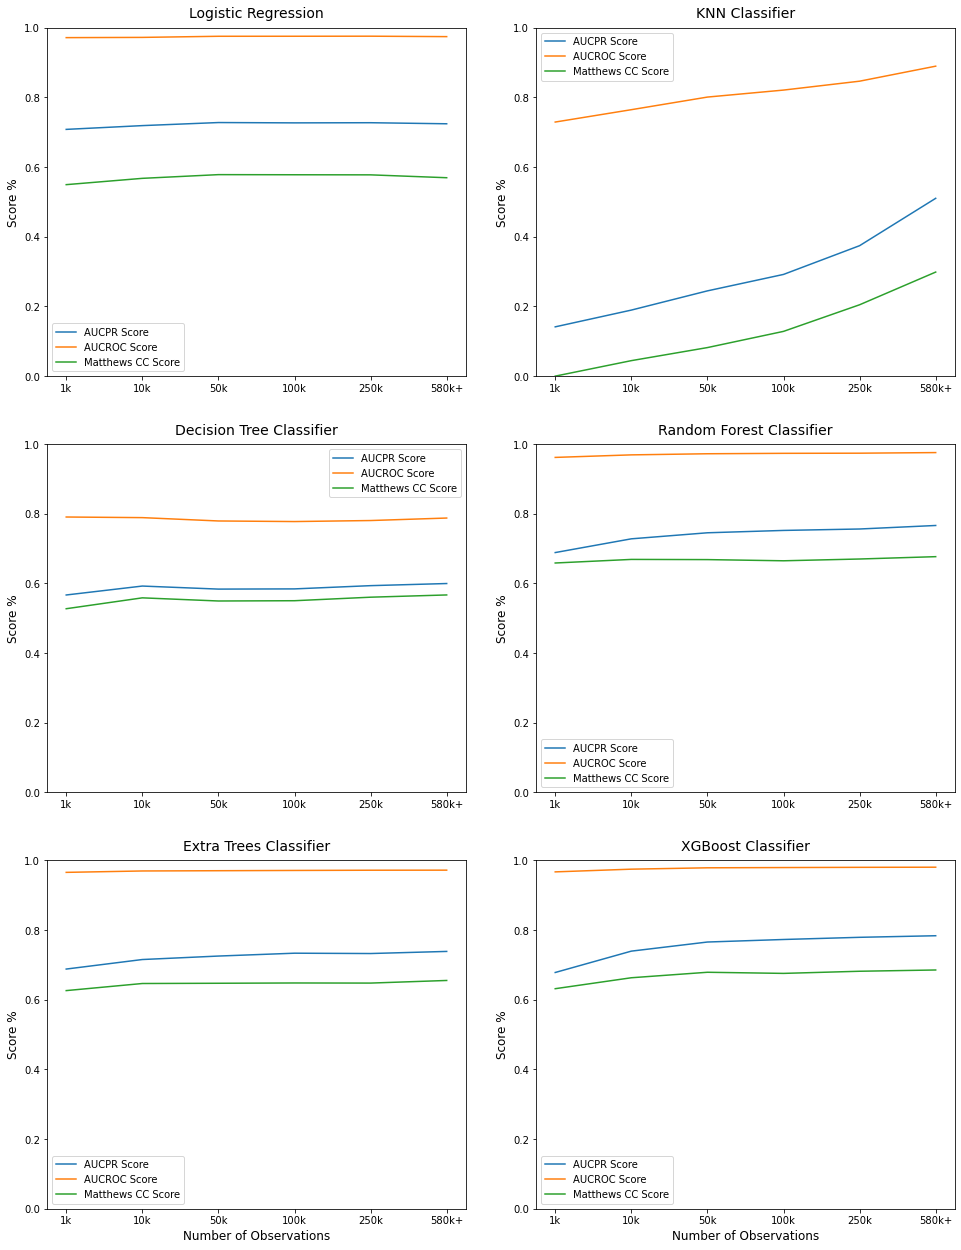

In [37]:
fig, axes = plt.subplots(3, 2, figsize=(14, 18))
axes = axes.flatten()
for (name, _), ax in zip(estimators, axes):
    ax.plot([d[name][set_name]['AUCPR'] for set_name in sets], label='AUCPR Score')
    ax.plot([d[name][set_name]['AUCROC'] for set_name in sets], label='AUCROC Score')
    ax.plot([d[name][set_name]['matthews'] for set_name in sets], label='Matthews CC Score')
    ax.set_ylim(0, 1)
    ax.set_xticks(range(len(sets)))
    ax.set_xticklabels(['1k', '10k', '50k', '100k', '250k', '580k+'])
    if ax in axes[-2:]:
        ax.set_xlabel('Number of Observations', size=12)
    ax.set_ylabel('Score %', size=12)
    ax.set_title(name, pad=10, size=14)
    ax.legend()
plt.tight_layout(3)
plt.show()

# Conclusion

        In this project, we aimed to come up with a model which can predict if a freshly posted
        review will be a helpful reviews. If so, the businesses can benefit this kind of an approach
        by promoting those reviews and let the customers enjoy them. 
        Since, the most important components of a helpful review are the number of customer who voted
        for the review and the amount of time passed since it posted. By doing so, we hoped to save
        the amount of time that would required a reviews to be recognized as a helpful review and
        provide those reviews for the convenience of the customers.
        
        We started with the review corpus in order to identify the helpful reviews. First, we implemented
        text cleaning steps in order to ready the text for vectorization. Later, we used Tf-Idf method
        to vectorize the text and set the following cut-off points for the minimum and the maximum 
        number of documents for a word has to be appeared as 3% and 90%, respectively.
        
        However, the Tf-Idf vector was not an efficient way to identify helpful reviews as it was 
        detecting star rating of the reviews. For this reason, we employed the features that are extracted
        from the reviews such as the number of photos, the number of price information, the average helpful
        vote that the writer have etc. As a result, we improved the model performances.
        
        Later, we did hyperparameter optimization using the extracted features in order to find the parameter
        values that explain the data best. Finally, in this notebook, we trained the models using the whole
        training set and evaluated the results with the test set.
        
        In order to increase the recall rate we focused on the reviews that have at least 0.95 assigned
        probability. As a result, we got the highest recall rate by using XGBoost Classifier. But the best
        result are acquired by KNN classifier.
        
        In the final step, we evaluated the model performances by training models with six subset of the 
        training set in which they differ in the number of reviews. However, we kept the test set stable.
        The aim is to get an idea how the model performances change as the dataset grows. We found that the
        best improvement experienced with KNN classifier.
        
        As a result, we think that the best algorithm, in order to identify helpful reviews with the given
        feature set and the given conditions such as 0.95 probability cut-off, is KNN algorithm. Being said that
        we claim KNN is able to detect the reviews which have the highest number of helpful votes with great
        accuracy. Even though its recall rate is lower than some of the other algorithms it is the best in order
        to recommend the highest number of helpful reviews.
        
        Here, we give an example of helpful reviews which have assigned probability over 0.95 with the number of
        helpful votes they got. The business can have the benefit of the machine learning applications in order
        to detect helpful reviews in advance and enhance their customer relationship.

# Examples

In [40]:
indices = temp[temp.knn_probas >= 0.95].index
idx = np.random.randint(len(indices), size=7)
indices = list(indices[idx])

In [41]:
for idx in indices:
    print("""
            The number of helpful votes: {}
            
          """.format(df.iloc[idx].review_useful))
    print(df.iloc[idx].review)
    print('-+' * 80)


            The number of helpful votes: 27
            
          
Nora's is one of those places that is consistently good but somehow never on my radar unless I'm driving by- usually right after eating somewhere else. Luckily, a coworker insisted on dinner here so I finally got a chance to visit since their relocation, which puts their great food and attentive service (especially from Don!) in a suitably beautiful setting.

Started with a round of house salads, fresh with a great house dressing, plus their house garlic bread I raved about on my initial visit (spoiler alert: it's still amazing!). Tried the decadent carbonara, which I'll definitely be back for, but ultimately opted for my old standby, the Alla Nora (baked spaghetti topped with eggplant, meat sauce, and pesto) and was not disappointed. Kicked it up with a third course of chicken marsala and lamb shank, which was a huge, beautiful portion, perfectly cooked.  Might as well go big and have dessert after all that; the pann